## Glmnet Vignette (for python)
#### Trevor Hastie and B. J. Balakumar (Stanford University)

## Linear Regression: Gaussian family

`gaussian ` is the default family option in the function `glmnet`. Suppose we have observations $x_i \in \mathbb{R}^p$ and the responses $y_i \in \mathbb{R}, i = 1, \ldots, N$. The objective function for the Gaussian family is
$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}}\frac{1}{2N} \sum_{i=1}^N (y_i -\beta_0-x_i^T \beta)^2+\lambda \left[ (1-\alpha)||\beta||_2^2/2 + \alpha||\beta||_1\right],
$$
where $\lambda \geq 0$ is a complexity parameter and $0 \leq \alpha \leq 1$ is a compromise between ridge ($\alpha = 0$) and lasso ($\alpha = 1$).

Coordinate descent is applied to solve the problem. Specifically, suppose we have current estimates $\tilde{\beta_0}$ and $\tilde{\beta}_\ell$ $\forall j\in 1,]\ldots,p$. By computing the gradient at $\beta_j = \tilde{\beta}_j$ and simple calculus, the update is
$$
\tilde{\beta}_j \leftarrow \frac{S(\frac{1}{N}\sum_{i=1}^N x_{ij}(y_i-\tilde{y}_i^{(j)}),\lambda \alpha)}{1+\lambda(1-\alpha)},
$$
where $\tilde{y}_i^{(j)} = \tilde{\beta}_0 + \sum_{\ell \neq j} x_{i\ell} \tilde{\beta}_\ell$, and $S(z, \gamma)$ is the soft-thresholding operator with value $\text{sign}(z)(|z|-\gamma)_+$.

This formula above applies when the `x` variables are standardized to have unit variance (the default); it is slightly more complicated when they are not. Note that for "family=gaussian", `glmnet` standardizes $y$ to have unit variance before computing its lambda sequence (and then unstandardizes the resulting coefficients); if you wish to reproduce/compare results with other software, best to supply a standardized $y$ first (Using the "1/N" variance formula).

`glmnet` provides various options for users to customize the fit. We introduce some commonly used options here and they can be specified in the `glmnet` function.

* `alpha` is for the elastic-net mixing parameter $\alpha$, with range $\alpha \in [0,1]$. $\alpha = 1$ is the lasso (default) and $\alpha = 0$ is the ridge.

* `weights` is for the observation weights. Default is 1 for each observation. (Note: `glmnet` rescales the weights to sum to N, the sample size.)

* `nlambda` is the number of $\lambda$ values in the sequence. Default is 100.

* `lambda` can be provided, but is typically not and the program constructs a sequence. When automatically generated, the $\lambda$ sequence is determined by `lambda.max` and `lambda.min.ratio`. The latter is the ratio of smallest value of the generated  $\lambda$ sequence (say `lambda.min`) to `lambda.max`.  The program then generated `nlambda` values linear on the log scale from `lambda.max` down to `lambda.min`. `lambda.max` is not given, but easily computed from the input $x$ and $y$; it is the smallest value for `lambda` such that all the coefficients are zero.  For `alpha=0` (ridge) `lambda.max` would be $\infty$; hence for this case we pick a value corresponding to a small value for `alpha` close to zero.)

* `standardize` is a logical flag for `x` variable standardization, prior to fitting the model sequence. The coefficients are always returned on the original scale. Default is `standardize=TRUE`.

For more information, type `help(glmnet)` or simply `?glmnet`.

As an example, we set $\alpha = 0.2$ (more like a ridge regression), and give double weights to the latter half of the observations. To avoid too long a display here, we set `nlambda` to 20. In practice, however, the number of values of $\lambda$ is recommended to be 100 (default) or more. In most cases, it does not come with extra cost because of the warm-starts used in the algorithm, and for nonlinear models leads to better convergence properties.

In [115]:
# Import relevant modules and setup for calling glmnet

%matplotlib inline

import sys
sys.path.append('../test')
sys.path.append('../lib')

import scipy
import importlib
import pprint

import glmnet 
import glmnetPlot
import glmnetPrint
import glmnetCoef
import glmnetPredict

import cvglmnet
import cvglmnetPlot

importlib.reload(glmnet)
importlib.reload(glmnetPlot)    
importlib.reload(glmnetPrint)
importlib.reload(glmnetCoef)    
importlib.reload(glmnetPredict)

importlib.reload(cvglmnet)    
importlib.reload(cvglmnetPlot)

# parameters
baseDataDir= '../data/'

# load data
x = scipy.loadtxt(baseDataDir + 'QuickStartExampleX.dat', dtype = scipy.float64)
y = scipy.loadtxt(baseDataDir + 'QuickStartExampleY.dat', dtype = scipy.float64)

# create weights
t = scipy.ones((50, 1), dtype = scipy.float64)
wts = scipy.row_stack((t, 2*t))

In [116]:
# call glmnet
fit = glmnet.glmnet(x = x.copy(), y = y.copy(), family = 'gaussian', \
                    weights = wts, \
                    alpha = 0.2, nlambda = 20
                    )

We can then print the `glmnet` object.

In [117]:
glmnetPrint.glmnetPrint(fit)

	 df 	 %dev 	 lambdau

0 	 0.000000 	 0.000000 	 7.939020
1 	 4.000000 	 0.178852 	 4.889231
2 	 7.000000 	 0.444488 	 3.011024
3 	 7.000000 	 0.656716 	 1.854334
4 	 8.000000 	 0.784984 	 1.141988
5 	 9.000000 	 0.853935 	 0.703291
6 	 10.000000 	 0.886693 	 0.433121
7 	 11.000000 	 0.902462 	 0.266737
8 	 14.000000 	 0.910135 	 0.164269
9 	 17.000000 	 0.913833 	 0.101165
10 	 17.000000 	 0.915417 	 0.062302
11 	 17.000000 	 0.916037 	 0.038369
12 	 19.000000 	 0.916299 	 0.023629
13 	 20.000000 	 0.916405 	 0.014552
14 	 20.000000 	 0.916447 	 0.008962
15 	 20.000000 	 0.916463 	 0.005519
16 	 20.000000 	 0.916469 	 0.003399


This displays the call that produced the object `fit` and a three-column matrix with columns `Df` (the number of nonzero coefficients), `%dev` (the percent deviance explained) and `Lambda` (the corresponding value of $\lambda$).

(Note that the `digits` option can used to specify significant digits in the printout.)

Here the actual number of $\lambda$'s here is less than specified in the call. The reason lies in the stopping criteria of the algorithm. According to the default internal settings, the computations stop if either the fractional change in deviance down the path is less than $10^{-5}$ or the fraction of explained deviance reaches $0.999$. From the last few lines , we see the fraction of deviance does not change much and therefore the computation ends when meeting the stopping criteria. We can change such internal parameters. For details, see the Appendix section or type `help(glmnet.control)`.

We can plot the fitted object as in the previous section. There are more options in the `plot` function.

Users can decide what is on the X-axis. `xvar` allows three measures: "norm" for the $\ell_1$-norm of the coefficients (default), "lambda" for the log-lambda value and "dev" for %deviance explained.

Users can also label the curves with variable sequence numbers simply by setting `label = TRUE`. Let's plot "fit" against the log-lambda value and with each curve labeled.

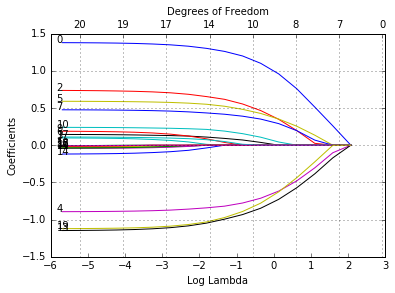

In [118]:
glmnetPlot.glmnetPlot(fit, xvar = 'lambda', label = True)

Now when we plot against %deviance we get a very different picture. This is percent deviance explained on the training data. What we see here is that toward the end of the path this value are not changing much, but the coefficients are "blowing up" a bit. This lets us focus attention on the parts of the fit that matter. This will especially be true for other models, such as logistic regression.

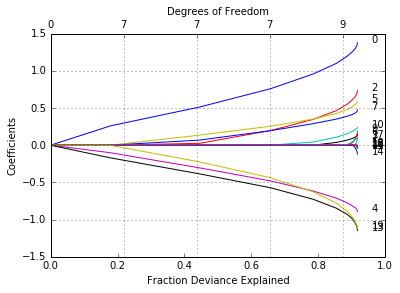

In [119]:
glmnetPlot.glmnetPlot(fit, xvar = 'dev', label = True)

We can extract the coefficients and make predictions at certain values of $\lambda$. Two commonly used options are:

* `s` specifies the value(s) of $\lambda$ at which extraction is made.

* `exact` indicates whether the exact values of coefficients are desired or not. That is, if `exact = TRUE`, and predictions are to be made at values of s not included in the original fit, these values of s are merged with `object$lambda`, and the model is refit before predictions are made. If `exact=FALSE` (default), then the predict function uses linear interpolation to make predictions for values of s that do not coincide with lambdas used in the fitting algorithm.

A simple example is:

In [120]:
any(fit['lambdau'] == 0.5)

False

In [121]:
coefApprx = glmnetCoef.glmnetCoef(fit, s = scipy.float64([0.5]), exact = False)
print(coefApprx)

[[ 0.19909875]
 [ 1.17465045]
 [ 0.        ]
 [ 0.53193465]
 [ 0.        ]
 [-0.76095948]
 [ 0.46820941]
 [ 0.06192676]
 [ 0.38030149]
 [ 0.        ]
 [ 0.        ]
 [ 0.14326099]
 [ 0.        ]
 [ 0.        ]
 [-0.91120737]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.00919663]
 [ 0.        ]
 [-0.86311705]]


The output is for `False`.*(TBD) The exact = 'True' option is not yet implemented*. We see from the above that 0.01 is not in the sequence and that hence there are some difference, though not much. Linear interpolation is mostly enough if there are no special requirements.

Users can make predictions from the fitted object. In addition to the options in `coef`,  the primary argument is `newx`, a matrix of new values for `x`. The `type` option allows users to choose the type of prediction:
* "link" gives the fitted values

* "response" the sames as "link" for "gaussian" family.

* "coefficients" computes the coefficients at values of `s`

* "nonzero" retuns a list of the indices of the nonzero coefficients for each value of `s`.

For example,


In [122]:
fc = glmnetPredict.glmnetPredict(fit, x[0:5,:], ptype = 'response', \
                                s = scipy.float64([0.05]))
print(fc)

[[-0.98025907]
 [ 2.29924528]
 [ 0.60108862]
 [ 2.35726679]
 [ 1.75204208]]


gives the fitted values for the first 5 observations at $\lambda = 0.05$. If multiple values of `s` are supplied, a matrix of predictions is produced.

Users can customize K-fold cross-validation. In addition to all the `glmnet` parameters, `cvglmnet` has its special parameters including `nfolds` (the number of folds), `foldid` (user-supplied folds), `ptype`(the loss used for cross-validation):

* "deviance" or "mse" uses squared loss

* "mae" uses mean absolute error

As an example,

In [123]:
   cvfit = cvglmnet.cvglmnet(x = x.copy(), y = y.copy(), ptype = 'mse', nfolds = 20)

does 20-fold cross-validation, based on mean squared error criterion (default though).

*(TBD) Parallel computing is currently not supported by `cvglmnet`.*

As suggested from the above, parallel computing can significantly speed up the computation process especially for large-scale problems.

Functions `coef` and `predict` on cv.glmnet object are similar to those for a `glmnet` object, except that two special strings are also supported by `s` (the values of $\lambda$ requested):

* "lambda.1se": the largest $\lambda$ at which the MSE is within one standard error of the minimal MSE.

* "lambda.min": the $\lambda$ at which the minimal MSE is achieved.

In [124]:
cvfit['lambda_min']

array([ 0.07569327])

In [126]:
glmnetCoef.glmnetCoef(cvfit, s = scipy.float64([0.07569327]), exact = False)

UnboundLocalError: local variable 'result' referenced before assignment

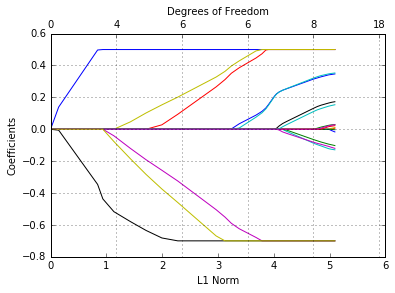

In [127]:
cl = scipy.array([[-0.7], [0.5]], dtype = scipy.float64)
tfit=glmnet.glmnet(x = x.copy(),y= y.copy(), cl = cl)
glmnetPlot.glmnetPlot(tfit)